# Analyse results

Useful references:
* https://pypsa.readthedocs.io/en/latest/examples/scigrid-lopf-then-pf.html (example from PyPSA documentation with many different visualisations)

## Setup and helpers

In [91]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml

# plotting settings
plt.style.use('ggplot') # what is this?
plt.rcParams['figure.figsize'] = (6, 6)
projection = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52) # good for Europe

# Load the network
network_file = "results/normal/networks/elec_s_39_ec_lcopt_.nc"
network = pypsa.Network(network_file)

# Load the config file
with open("config/config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

def plot_europe(fig, ax):
    ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree()) # Europe
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', alpha=0.8)
    ax.add_feature(cfeature.RIVERS, edgecolor='lightblue', alpha=0.8)

    gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels

    return fig, ax

INFO:pypsa.io:Imported network elec_s_39_ec_lcopt_.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Network map

/Users/jopeel/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x17b048e90>,
 <matplotlib.collections.LineCollection at 0x17b19e750>)

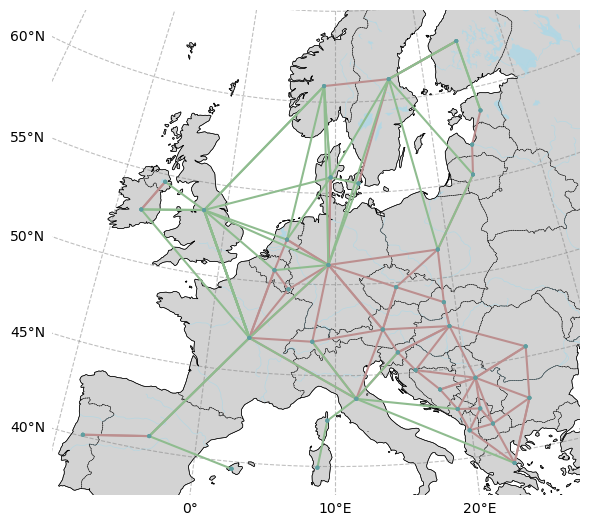

In [92]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})

fig, ax = plot_europe(fig, ax)

network.plot(ax=ax)

## Load distribution map

/Users/jopeel/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x17b180e60>,
 <matplotlib.collections.LineCollection at 0x17af53380>)

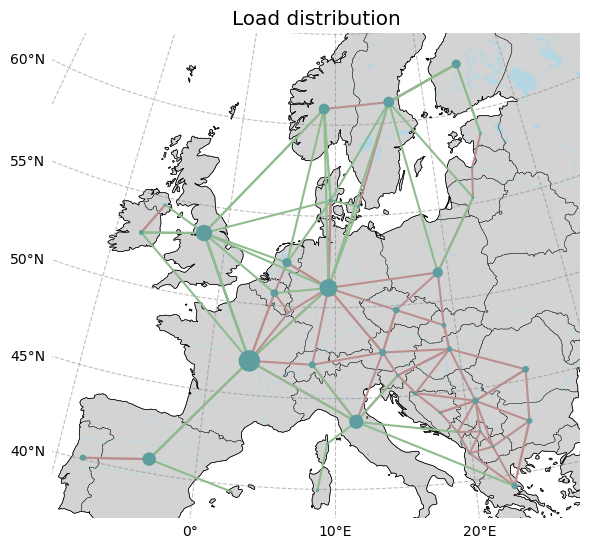

In [93]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": projection})

fig, ax = plot_europe(fig, ax)

load_distribution = (
    network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()
)

network.plot(bus_sizes=1e-5 * load_distribution, ax=ax, title="Load distribution")

## Installed capacities table

In [94]:
network.generators.groupby("carrier")["p_nom"].sum()

carrier
CCGT               0.000000
OCGT               0.000000
offwind-ac      9926.020714
offwind-dc     15070.984836
onwind        184705.429522
ror            46063.307854
solar         152542.411939
Name: p_nom, dtype: float64

In [95]:
network.storage_units.groupby("carrier")["p_nom"].sum()

carrier
PHS       56877.540000
hydro    103182.439657
Name: p_nom, dtype: float64

## Dispatch plot (WiP)

carrier              Combined-Cycle Gas  Open-Cycle Gas  Offshore Wind (AC)  \
snapshot                                                                      
2013-01-01 00:00:00                 0.0             0.0        36403.785873   
2013-01-01 01:00:00                 0.0             0.0        36458.853669   
2013-01-01 02:00:00                 0.0             0.0        36664.080305   
2013-01-01 03:00:00                 0.0             0.0        37187.033382   
2013-01-01 04:00:00                 0.0             0.0        36906.240791   
...                                 ...             ...                 ...   
2013-12-31 19:00:00                 0.0             0.0        48815.122926   
2013-12-31 20:00:00                 0.0             0.0        49265.382084   
2013-12-31 21:00:00                 0.0             0.0        48623.980777   
2013-12-31 22:00:00                 0.0             0.0        47532.652831   
2013-12-31 23:00:00                 0.0             

/var/folders/cd/3symzw7d0833vd8qj4shbrl80000gp/T/ipykernel_31959/971097879.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



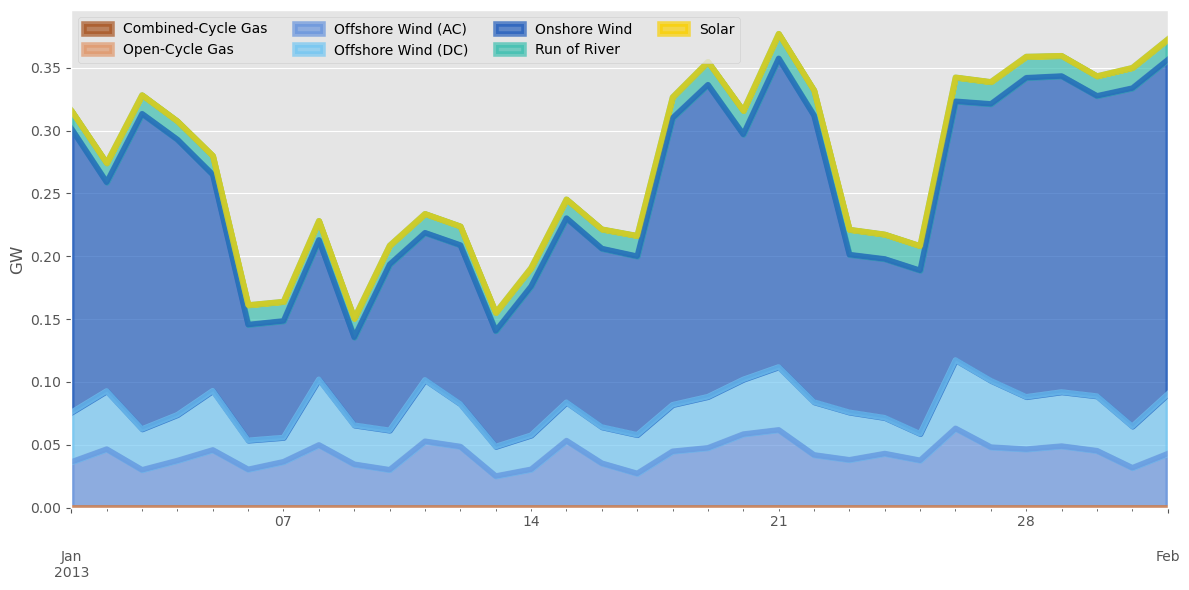

In [108]:
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

all_colors = config["plotting"]["tech_colors"]

colors = [all_colors[col] for col in p_by_carrier.columns]

p_by_carrier.rename(columns=config["plotting"]["nice_names"], inplace=True)
print(p_by_carrier)

time_range = pd.date_range(start="2013-01-01 00:00:00", end="2013-02-01 00:00:00")
p_by_carrier = p_by_carrier.loc[time_range]

p_by_carrier = p_by_carrier / 1e3

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=4, color=colors, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()